# Summary statistics

## Load libraries

In [1]:
import os
import time
import scanpy as sc
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

## Script configurations

### Define directory locations (Change according to folder structure preferred)

In [2]:
mainDir = '/Users/rudi/Data/TS_codes/' #change this line to your folder structure
dataDir = ''.join([mainDir, 'data/'])
rawDir = ''.join([dataDir, 'raw/'])
processedDir = ''.join([dataDir, 'processed/'])
figDir = ''.join([mainDir, 'Statistics/figures/'])

os.chdir(mainDir)

### Scanpy filename specific report locations

In [3]:
tissue = 'all'
plotDir = ''.join([figDir, tissue, '/'])
if os.path.isdir(plotDir):
    print("Folder already exists")
else:
    print("Folder doesn't exist.Creating new folder!")
    os.mkdir(plotDir)

plotDir = ''.join([plotDir, 'mrna_'])
sc.settings.figdir = plotDir

Folder already exists


### Set scanpy parameters

In [4]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.n_jobs=2
sc.settings.verbosity = 1
sns.set_style("ticks", {'axes.grid' : False})

# sc.logging.print_header()

## Load Tabula sapiens data

In [6]:
t = time.time()
tabula_file = ''.join([processedDir, 'TS_norm_log1p.h5ad'])
tabula = sc.read_h5ad(tabula_file)
tabula = tabula[-tabula.obs['cell_type'].isin(['erythrocyte', 'platelet']), :].copy()

print("Time to execute: {:.2f} mins".format((time.time() - t)/60))

## Get glycogenes

In [8]:
# Subset data based on sequencing technology(10X or Smart-Seq) 
tabula = tabula[tabula.obs['assay']=='10x 3\' v3'] #Use for 10X

#%% Subset data to specific genes (in this case protein-coding transcripts only)
genes_found = pd.read_csv(''.join([dataDir, 'Tabulagenes_ensemblmetadata.csv'])) # BioMart mapping of genes
types_of_genes = genes_found['gene_biotype'] #Gene biotype has info on which type of RNA each ensembl id is mapped to

# Display the counts of different transcript types
print('The types of genes found in dataset are:')
print(types_of_genes.value_counts())

# Merge ensembl id mapping with Tabula variables
tabula.var = (tabula.var.reset_index().
              merge(genes_found, how = 'left', left_on = 'gene_id', right_on = 'ensembl_gene_id').
              set_index('gene_id')) #Merge the info of mapping to adata object

#%% Load GlycoEnzOnto gene sets and subset data to glycogenes
glycoOntoDir = ''.join([dataDir, 'GlycoEnzOnto/'])
GlycoEnzOntoFile = ''.join([glycoOntoDir, 'GlycoEnzOntoEns.json'])# Ensembl IDs of all glycogenes
with open(GlycoEnzOntoFile, 'r') as json_file:
    glycoSet = json.load(json_file)

GlycoEnzOntoFile = ''.join([glycoOntoDir, 'GlycoEnzOnto.json'])# Gene symbols of all glycogenes
with open(GlycoEnzOntoFile, 'r') as json_file:
    glycoSetnames = json.load(json_file)

# Filter glyco gene sets to gene symbols in data
glycoSetnames_filter = {k: list({e for i, e in enumerate(v) if e in tabula.var['feature_name'].tolist()}) 
            for k, v in glycoSetnames.items()}

# Filter glyco gene sets to ensembleID in data
glycoSet_filter = {k: list({e for i, e in enumerate(v) if e in tabula.var.index.tolist()}) 
            for k, v in glycoSet.items()}

# Get merged list of glycogenes detected in dataset and remove duplicates
glycoGeneNames = list({e for k, v in glycoSetnames_filter.items() for i, e in enumerate(v)}) 
glycoGenes = list({e for k, v in glycoSet_filter.items() for i, e in enumerate(v)})

# Check missing glycogenes in dataset
glycoGeneNames_notfound ={e for k, v in glycoSetnames.items() for i, e in enumerate(v)} - set(tabula.var['feature_name'].tolist())
glycoGenes_notfound ={e for k, v in glycoSet.items() for i, e in enumerate(v)} - set(tabula.var.index.tolist())

print('Glycogenes missing in dataset are:')
print(glycoGeneNames_notfound)

#Add additional column to data.var to indicate if genes are glycogenes
tabula.var['isglyco'] = tabula.var['feature_name'].isin(glycoGeneNames)

The types of genes found in dataset are:
protein_coding                        19847
lncRNA                                14936
processed_pseudogene                  10114
unprocessed_pseudogene                 2567
misc_RNA                               2210
snRNA                                  1901
miRNA                                  1875
TEC                                    1048
snoRNA                                  941
transcribed_unprocessed_pseudogene      940
transcribed_processed_pseudogene        506
rRNA_pseudogene                         494
IG_V_pseudogene                         187
transcribed_unitary_pseudogene          150
IG_V_gene                               145
TR_V_gene                               106
unitary_pseudogene                       96
TR_J_gene                                79
scaRNA                                   49
rRNA                                     47
IG_D_gene                                37
TR_V_pseudogene                    

## Load dictionary of enzyme definitions

In [9]:
enzymeFile = ''.join([dataDir, 'enzymes_dictionary.json'])# Gene symbols of all glycogenes
with open(enzymeFile, 'r') as json_file:
    enzymenames = json.load(json_file)
enzymenames['Glycosyltransferases'] = enzymenames.pop('glycoTs')
enzymenames['Glycosidases'] = enzymenames.pop('glycosidases')
enzymenames['Modifying enzymes'] = enzymenames.pop('modifying enzymes')
tabula.var['enzyme_func'] = 'Non-glycogenes'
tabula.var.loc[tabula.var['isglyco'], 'enzyme_func'] = 'Transporters & Regulators'

enzymenames_pd = (pd.DataFrame(enzymenames.items(), columns=['function', 'feature_name']).
     explode('feature_name').
     drop_duplicates())

for k, v in enzymenames.items():
    print(f"Genes in {k} not present in Tabula are: {set(v) - set(tabula.var.loc[tabula.var['feature_name'].isin(v), 'feature_name'])}")
    tabula.var.loc[tabula.var['feature_name'].isin(v), 'enzyme_func'] = k


Genes in Other transferases not present in Tabula are: set()
Genes in Glycosyltransferases not present in Tabula are: {'UGT1A5', 'GALNT19', 'UGT1A3'}
Genes in Glycosidases not present in Tabula are: set()
Genes in Modifying enzymes not present in Tabula are: set()


## Load GlycoEnzOnto gene set

### Load gene lists for glycopathways

In [8]:
glycoOntoDir = ''.join([rawDir, 'GlycoEnzOnto/'])
GlycoEnzOntoFile = ''.join([glycoOntoDir, 'GlycoEnzOnto.json'])# Gene symbols of all glycogenes
with open(GlycoEnzOntoFile, 'r') as json_file:
    glycoSetnames = json.load(json_file)

glycoSetnames_filter = {k: list({e for i, e in enumerate(v) if e in tabula.var['feature_name'].tolist()}) 
            for k, v in glycoSetnames.items()}

del glycoSetnames

### Load grouping of glycopathways

In [9]:
GlycoEnzOntoFile = ''.join([glycoOntoDir, 'GlycoEnzOntoGroup.json'])
with open(GlycoEnzOntoFile, 'r') as json_file:
    glycoGroups = json.load(json_file)

### Merge the glyco definitions

In [10]:
glycoSetnames_pd = (pd.DataFrame(glycoSetnames_filter.items(), columns=['pathway', 'feature_name']).
     explode('feature_name').
     drop_duplicates())
glycoGroups_pd = (pd.DataFrame(glycoGroups.items(), columns=['Groups', 'pathway']).
     explode('pathway').
     drop_duplicates())
glycoinfo_pd = glycoSetnames_pd.merge(glycoGroups_pd, how = 'left')

del glycoSetnames_pd, glycoGroups_pd

## Load core, extension and terminal pathways dict

### Load gene symbols of all core pathways

In [ ]:
GlycoEnzOntoFile = ''.join([glycoOntoDir, 'glyco_patws_dictf.json'])# Gene symbols of all glycogenes
with open(GlycoEnzOntoFile, 'r') as json_file:
    coreSetnames = json.load(json_file)

coreSetnames_pd = (pd.DataFrame(coreSetnames.items(), columns=['pathway', 'feature_name']).
                     explode('feature_name').
                     drop_duplicates())

### Load sub pathway definitions in core pathway

In [11]:
GlycoEnzOntoFile = ''.join([glycoOntoDir, 'glycoGroup_new_subf.json'])# Gene symbols of all glycogenes
with open(GlycoEnzOntoFile, 'r') as json_file:
    coreGroupnames = json.load(json_file)

coreGroupnames_pd = (pd.DataFrame(coreGroupnames.items(), columns=['Groups', 'pathway']).
                     explode('pathway').
                     drop_duplicates())



### Merge both core glycogene definitions

In [ ]:
coreinfo_pd = coreSetnames_pd.merge(coreGroupnames_pd, how = 'left')
coreinfo_pd['Groups'] = coreinfo_pd['Groups'].map({'core': 'Core', 'extension': 'Extension', 'terminal': 'Terminal'})

## Subset the data to 10X and protein_coding

In [12]:
tabula = tabula[tabula.obs['assay']=='10x 3\' v3'].copy() #Use for 10X
tabula = tabula[:, tabula.var['gene_biotype']=='protein_coding'].copy()

## Filter the data based on only protein-coding genes

In [13]:
sc.pp.filter_cells(tabula, min_genes = 200)
sc.pp.filter_genes(tabula, min_cells = 3)

## Calculate statistics prior to plotting

### Gene wise statistics

In [14]:
tabula.var['mean_expression'] = np.asarray(tabula.X.mean(axis = 0)).flatten().tolist()
tabula.var['n_cells'] = np.asarray((tabula.X>0).sum(axis = 0)).flatten().tolist()
tabula.var['fraction_cells'] = tabula.var['n_cells']/tabula.shape[0]

### Cellwise statistics

In [15]:
tabula.obs['mean_expression_genes'] = np.asarray(tabula.X.mean(axis = 1)).flatten().tolist()
tabula.obs['total_expression_genes'] = np.asarray(tabula.X.sum(axis = 1)).flatten().tolist()
tabula.obs['n_genes'] = np.asarray((tabula.X>0).sum(axis = 1)).flatten().tolist()

tabula.obs['mean_expression_glycogenes'] = np.asarray(tabula.X[:, tabula.var['isglyco']].mean(axis = 1)).flatten().tolist()
tabula.obs['total_expression_glycogenes'] = np.asarray(tabula.X[:, tabula.var['isglyco']].sum(axis = 1)).flatten().tolist()
tabula.obs['n_glycogenes'] = np.asarray((tabula.X[:, tabula.var['isglyco']]>0).sum(axis = 1)).flatten().tolist()

tabula.obs['mean_expression_nonglycogenes'] = np.asarray(tabula.X[:, -tabula.var['isglyco']].mean(axis = 1)).flatten().tolist()
tabula.obs['total_expression_nonglycogenes'] = np.asarray(tabula.X[:, -tabula.var['isglyco']].sum(axis = 1)).flatten().tolist()
tabula.obs['n_nonglycogenes'] = np.asarray((tabula.X[:, -tabula.var['isglyco']]>0).sum(axis = 1)).flatten().tolist()

### Statistics on raw counts

In [16]:
tabula.X = tabula.layers['decontXcounts'].copy()
tabula.obs['total_expression_genes_raw'] = np.asarray(tabula.X.sum(axis = 1)).flatten().tolist()
tabula.var['total_expression_raw'] = np.asarray(tabula.X.sum(axis = 0)).flatten().tolist()
tabula.var['mean_expression_raw'] = np.asarray(tabula.X.mean(axis = 0)).flatten().tolist()

## Plots

### Fig 1b

/scratch/14264127/ipykernel_128521/2918876324.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=16)


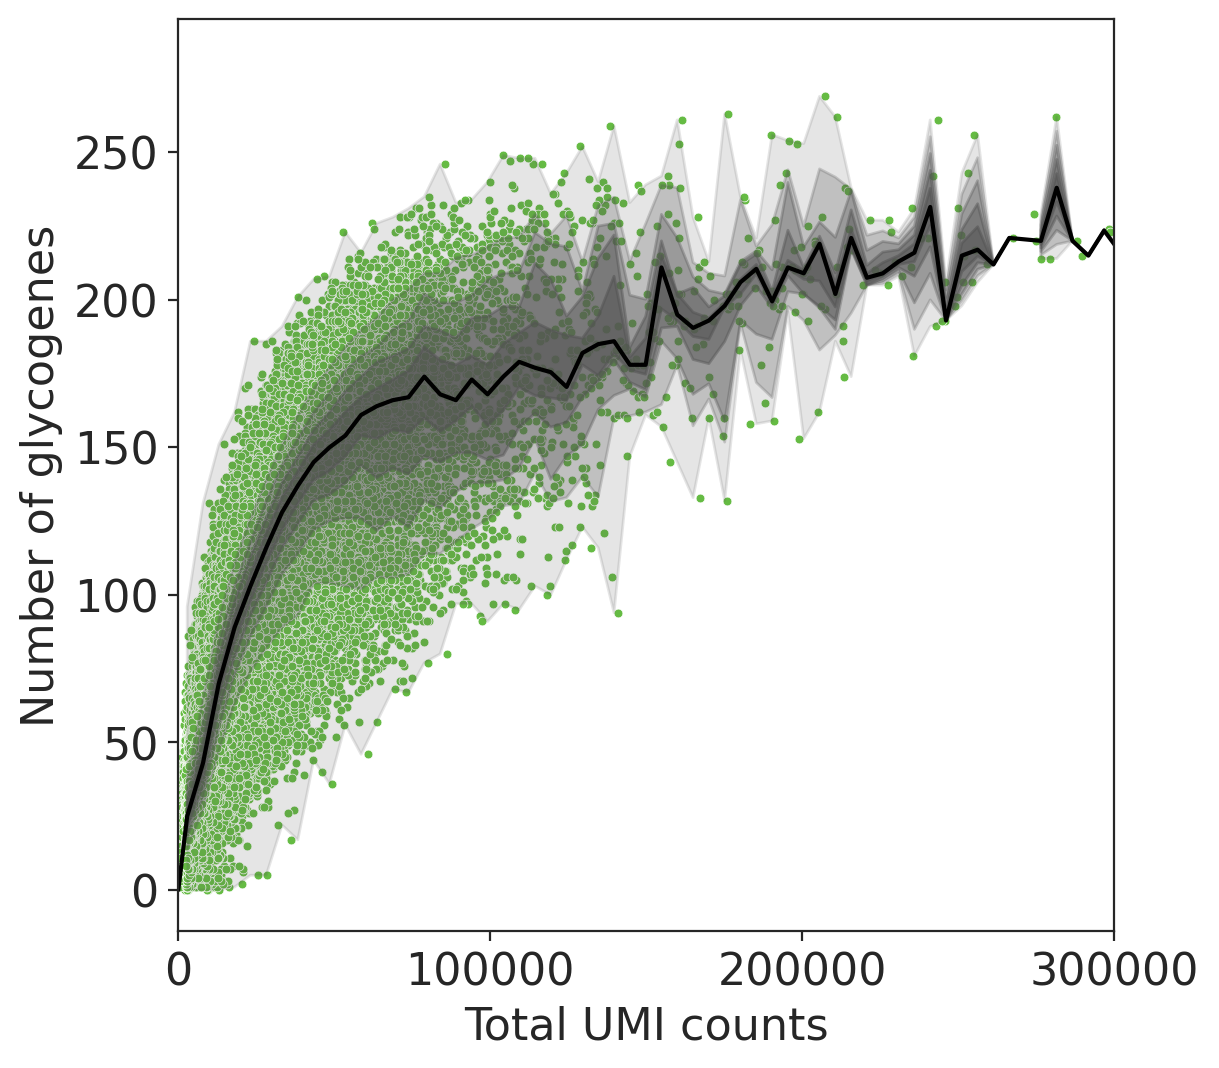

In [17]:
nbins = 100
SDist=np.zeros((nbins,11))
for i in range(11):
    quart = stats.binned_statistic(tabula.obs["total_expression_genes_raw"], 
                           tabula.obs["n_glycogenes"], statistic=lambda y, i=i: np.percentile(y, i*10), bins=nbins)
    SDist[:,i]=quart.statistic
    if i==0:
        bin_lengths = quart.bin_edges + (quart.bin_edges[1]-quart.bin_edges[0])/2
        
quart = stats.binned_statistic(tabula.obs["total_expression_genes_raw"], 
                       tabula.obs["n_genes"], statistic='median', bins=nbins)
# quart2 = stats.binned_statistic(tabula.obs["total_expression_genes_raw"], 
#                        tabula.obs["n_glycogenes"], statistic='median', bins=600)

with plt.rc_context({'figure.figsize': (6, 6)}):
    ax = sns.scatterplot(data = tabula.obs, x = "total_expression_genes_raw",
                      y = "n_glycogenes", s=10, color='#65BB43')
    ax.set_xlim((0,300000))
    # ax.set_ylim((0, 400))
    for i in range(5):
        alph=0.15+(i/10.)
        ax.fill_between(bin_lengths[:-1], SDist[:,0+i], SDist[:,10-i], color="#545454", alpha=alph)
        # ax.fill_between(x = bin_lengths[:-1], y1=upperquart.statistic, y2=lowerquart.statistic, alpha = 0.65, color='#515151')
    a = sns.lineplot(x = np.insert(bin_lengths[:-1], 0, 0), y = np.insert(SDist[:,5],0,0), ax = ax, color='black', alpha=1)
    ax.set_xlabel('Total UMI counts', fontsize=16)
    ax.set_ylabel('Number of glycogenes', fontsize=16)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=16)
    fig = ax.get_figure()
    fig.show()
    # fig.savefig(''.join([plotDir, 'glyco_per_read.png']), bbox_inches = 'tight')

# plt.close()

del i, quart, SDist, alph

### Fig 1c

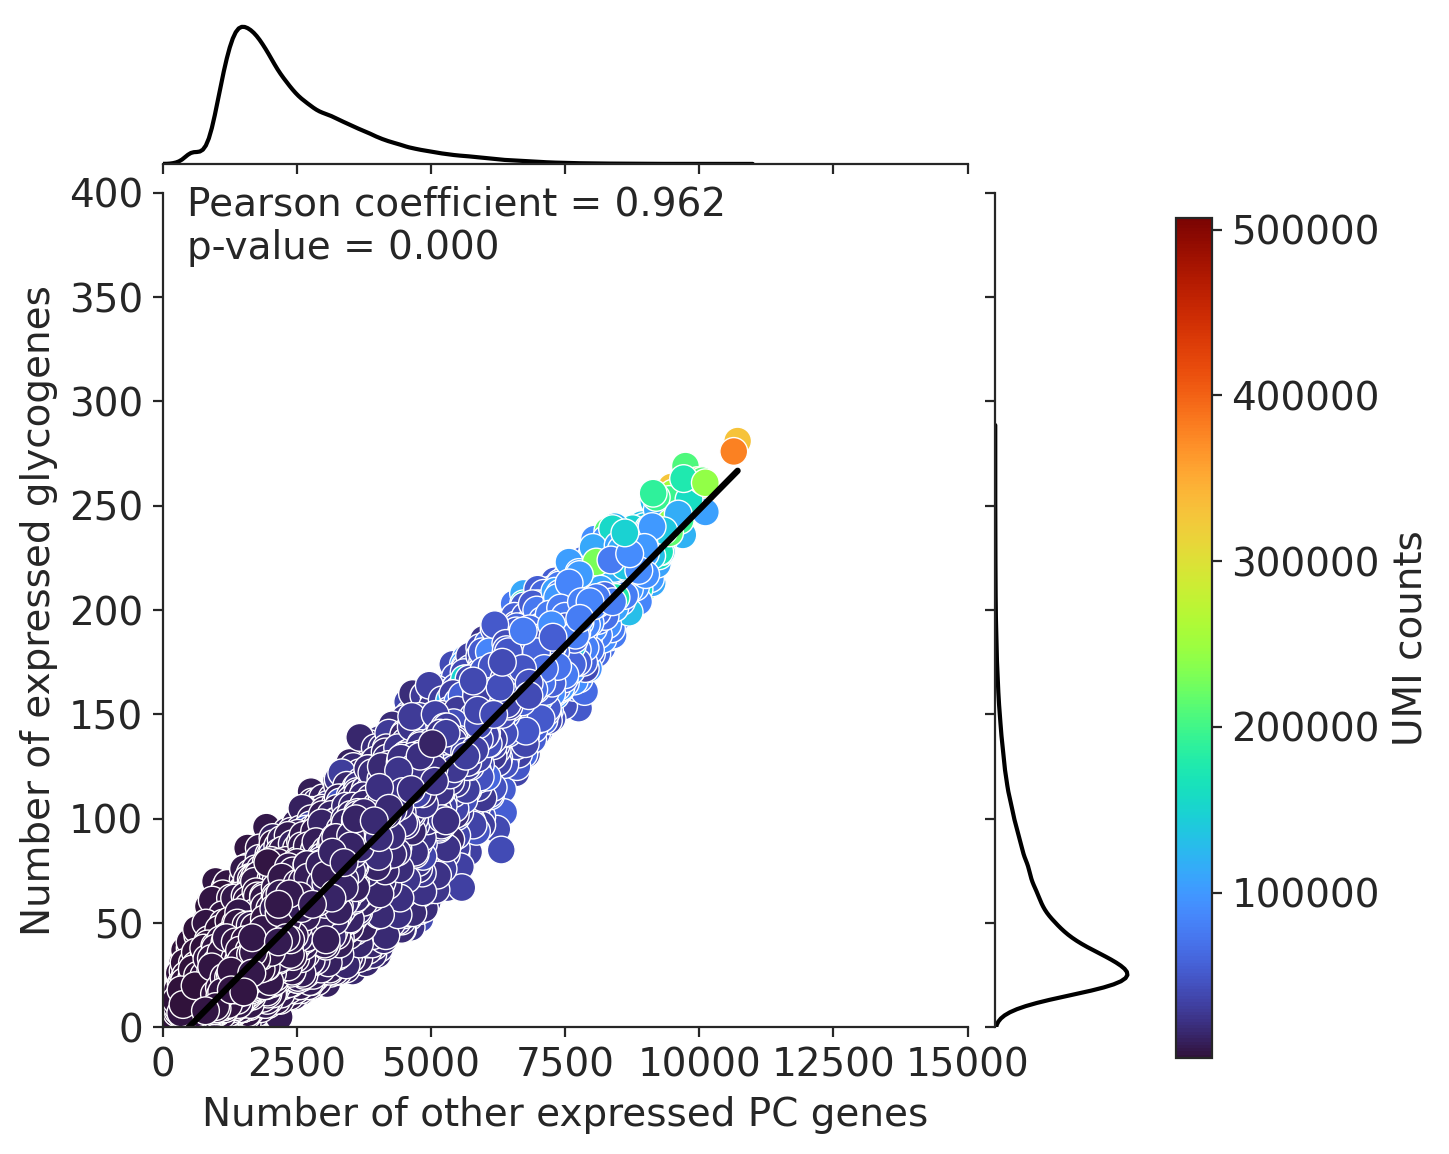

In [18]:
with plt.rc_context({'figure.figsize': (6, 6)}):
    c = tabula.obs['total_expression_genes_raw']
    g = sns.JointGrid(data = tabula.obs, x = "n_nonglycogenes", xlim = (0, 15000),
                      ylim = (0, 400), y = "n_glycogenes")
    g.plot_marginals(sns.kdeplot, color='black')
    
    norm = mpl.colors.Normalize(vmin=c.min(),vmax=c.max())
    a = sns.scatterplot(data = tabula.obs, s=100, hue='total_expression_genes_raw', 
                        x = "n_nonglycogenes", y = "n_glycogenes", ax=g.ax_joint, palette='turbo', hue_norm=norm, linewidth=0.5)
    a.legend_.remove()
    cbar_ax = g.fig.add_axes([1, 0.1, .03, .7])
    cb1  = mpl.colorbar.ColorbarBase(cbar_ax, cmap='turbo',norm=norm,orientation='vertical', label='UMI counts')
    cbar_ax.set_label('decont. UMI counts')
    g.plot_joint(sns.regplot, scatter = False, color = 'black')
    g.ax_joint.set_xlabel('Number of other expressed PC genes')
    g.ax_joint.set_ylabel('Number of expressed glycogenes')
    r, p = stats.pearsonr(tabula.obs['n_nonglycogenes'], tabula.obs['n_glycogenes'])
    g.ax_joint.annotate("Pearson coefficient = {:.3f}\np-value = {:.3f}".format(r, p), (0.03, 0.92),
                        xycoords = 'axes fraction')
    
plt.show()
    # g.savefig(''.join([plotDir, 'jointplot_allglyco10X.png']))

# plt.close()
    
del c, cb1, r, p

### Fig 1d

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glycogene vs. Not Glycogene: Mann-Whitney-Wilcoxon test two-sided, P_val:5.335e-05 U_stat=4.142e+06


/scratch/14264127/ipykernel_128521/2947170138.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/scratch/14264127/ipykernel_128521/2947170138.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(a, rotation=45, fontsize=12)


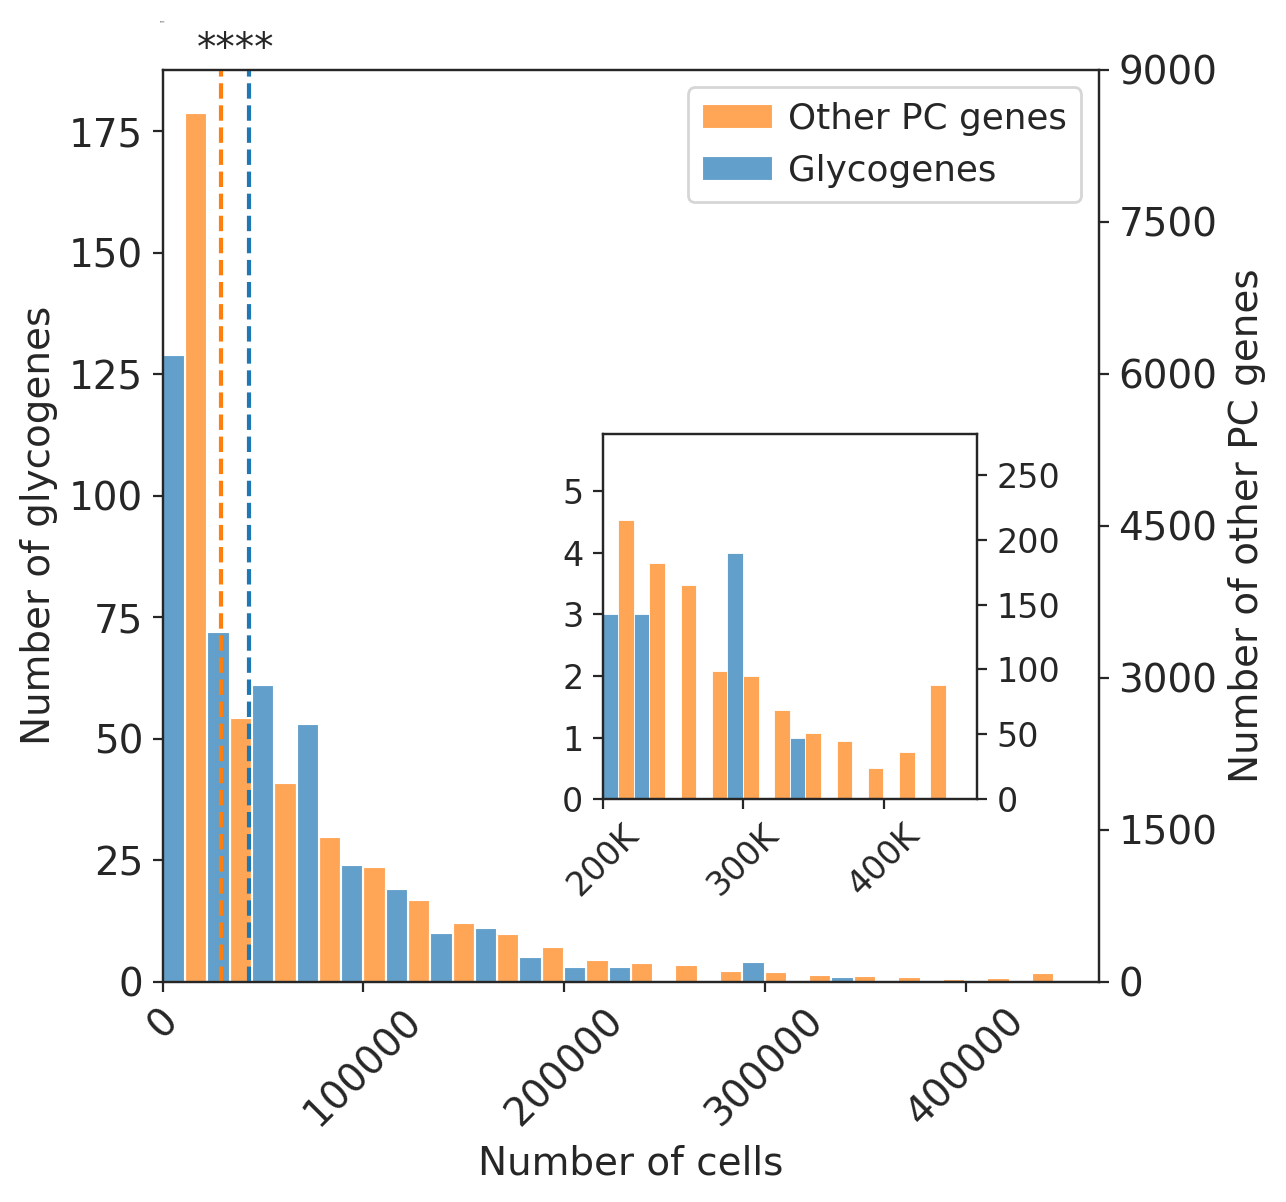

In [19]:
with plt.rc_context({'figure.figsize': (6, 6)}):
    ax = sns.histplot(data = tabula.var, x = 'n_cells', hue_order = ["Glycogene", "Not Glycogene"], #palette=['#FFFFFF','#C6BFBD'], 
                      stat = 'proportion', cumulative = False, alpha = 0.7, hue = 'isGlycogene',
                      common_norm = False, multiple = 'dodge', element = 'bars', log_scale = False, bins = 20)
    ax.set_xlim((0, ax.get_xlim()[1]))
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    
    glycotickvals = np.arange(tabula.var['isglyco'].value_counts()[1], step=25)
    glycoticks = glycotickvals/tabula.var['isglyco'].value_counts()[1]
    glycotickvals = glycotickvals[glycoticks<=ax.get_yticks().max()]
    glycoticks = glycoticks[glycoticks<=ax.get_yticks().max()]
    
    tickvals = np.arange(tabula.var['isglyco'].value_counts()[0], step=1500)
    ticks = tickvals/tabula.var['isglyco'].value_counts()[0]
    tickvals = tickvals[ticks<=ax.get_yticks().max()]
    ticks = ticks[ticks<=ax.get_yticks().max()]
    
    ax.set_yticks(glycoticks.tolist())
    ax.set_yticklabels(glycotickvals.tolist())
    
    ax2.set_yticks(ticks.tolist())
    ax2.set_yticklabels(tickvals.astype(int).tolist())
    
    samp1 = tabula.var.loc[-tabula.var['isglyco'], 'n_cells']
    samp2 = tabula.var.loc[tabula.var['isglyco'], 'n_cells']
    
    plt.axvline(np.quantile(samp2, 0.5), color='#1f77b4', linestyle = '--')
    plt.axvline(np.quantile(samp1, 0.5), color='#ff7f0e', linestyle = '--')
    ax.legend(title = '', labels = ["Other PC genes", "Glycogenes"], handlelength = 2)
    
    wilc, p1 = stats.ranksums(samp1, samp2)
    Mediandiff = samp1.median() - samp2.median()
    annotator = Annotator(ax, [("Glycogene", "Not Glycogene")], data=tabula.var, x='isGlycogene', y='n_cells', order=["Glycogene", "Not Glycogene"])
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', text_offset = 0)
    if Mediandiff>0:
        annotator.configure(color='g')
    else:
        annotator.configure(color = 'r')
    annotator.apply_and_annotate()
    
    stars = ax.texts[0].get_text()
    ax.texts[0].set_size(0)
    ax.text(np.mean([np.quantile(samp2, 0.5), np.quantile(samp1, 0.5)]),0.48, stars, horizontalalignment = 'center')#Change y from 0.48 as appropriate height from figure top
    ax.lines[-1].set_xdata((np.quantile(samp2, 0.5), np.quantile(samp2, 0.5), np.quantile(samp1, 0.5), np.quantile(samp1, 0.5)))
    ax.lines[-1].set_linewidth(0)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel('Number of glycogenes')
    ax2.set_ylabel('Number of other PC genes')
    ax.set_xlabel('Number of cells')
    
    axins = ax.inset_axes([.47, .2, .4, .4])
    
    sns.histplot(data = tabula.var, x = 'n_cells', hue_order = ["Glycogene", "Not Glycogene"], #palette=['#FFFFFF','#C6BFBD'], 
                          stat = 'proportion', cumulative = False, alpha = 0.7, hue = 'isGlycogene',
                          common_norm = False, multiple = 'dodge', element = 'bars', log_scale = False, bins = 20, ax=axins)
    axins.set_xlim((200000, axins.get_xlim()[1]))
    axins.set_ylim((0, 0.015))
    axins.get_legend().remove()
    axins2 = axins.twinx()
    axins2.set_ylim(axins.get_ylim())
    
    glycotickvals = np.arange(tabula.var['isglyco'].value_counts()[1], step=1)
    glycoticks = glycotickvals/tabula.var['isglyco'].value_counts()[1]
    glycotickvals = glycotickvals[glycoticks<=axins.get_yticks().max()]
    glycoticks = glycoticks[glycoticks<=axins.get_yticks().max()]
    
    tickvals = np.arange(tabula.var['isglyco'].value_counts()[0], step=50)
    ticks = tickvals/tabula.var['isglyco'].value_counts()[0]
    tickvals = tickvals[ticks<=axins.get_yticks().max()]
    ticks = ticks[ticks<=axins.get_yticks().max()]
    
    axins.set_yticks(glycoticks.tolist())
    axins.set_yticklabels(glycotickvals.tolist(), fontsize=12)
    
    axins2.set_yticks(ticks.tolist())
    axins2.set_yticklabels(tickvals.astype(int).tolist(), fontsize=12)
    a = [str(int(e))+'K' for i, e in enumerate(axins.get_xticks()/1000)]
    axins.set_xticklabels(a, rotation=45, fontsize=12)
    plt.xticks(rotation=45)
    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axins.set_xlabel('')
    axins.set_ylabel('')
    axins2.set_ylabel('')
    plt.show()
    # plt.savefig(''.join([plotDir, 'Genes_in_allcells10X_cdf.png']), bbox_inches='tight')
    # formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y)) # https://stackoverflow.com/a/49306588/3904031
    # axins.xaxis.set_major_formatter(formatter)
    # plt.close()

### Fig 1e

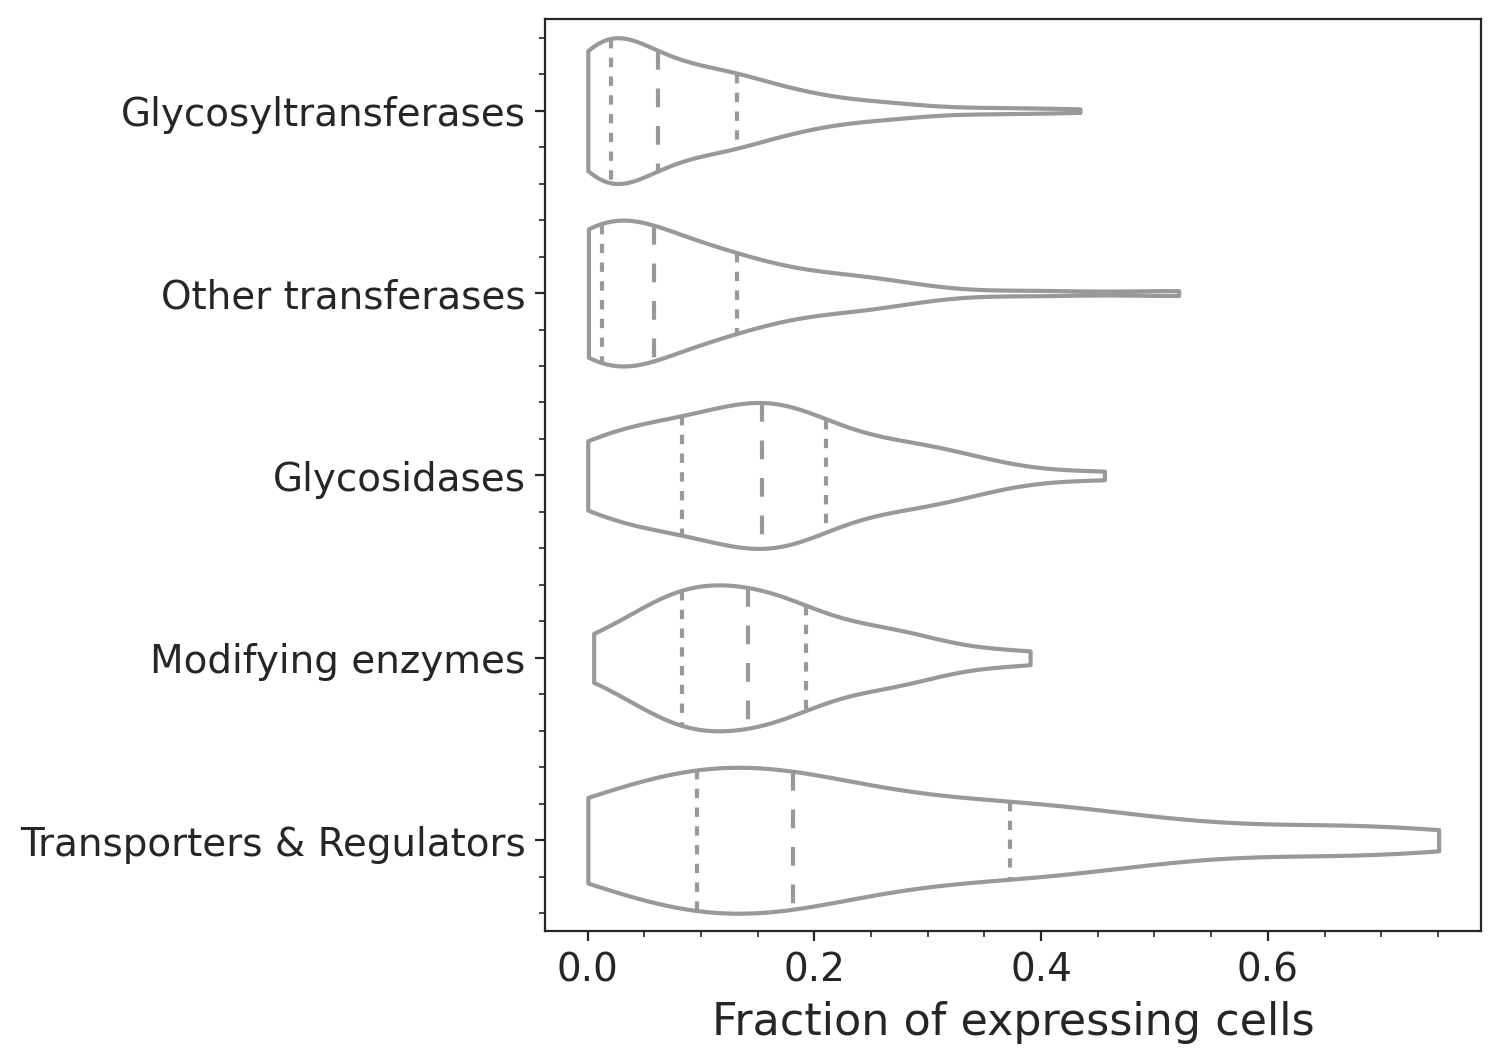

In [20]:
with plt.rc_context({'figure.figsize': (6, 6)}):
    ax = sns.violinplot(data = tabula.var[tabula.var['isglyco']], x = 'fraction_cells', palette=['#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF'], ##C6BFBD
                          y = 'enzyme_func', cut = 0, scale = 'width', inner = 'quartile', 
                          order = ['Glycosyltransferases', 'Other transferases', 'Glycosidases', 'Modifying enzymes', 'Transporters & Regulators'])
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)
    ax.set_xlabel('Fraction of expressing cells', fontsize = 16)
    ax.xaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
    
    fig1 = ax.get_figure()
    fig.show()
    # fig1.savefig(''.join([plotDir, 'Genes_in_allcells10X_enzymefunc.png']), bbox_inches = 'tight')

# plt.close()

### Fig 1f

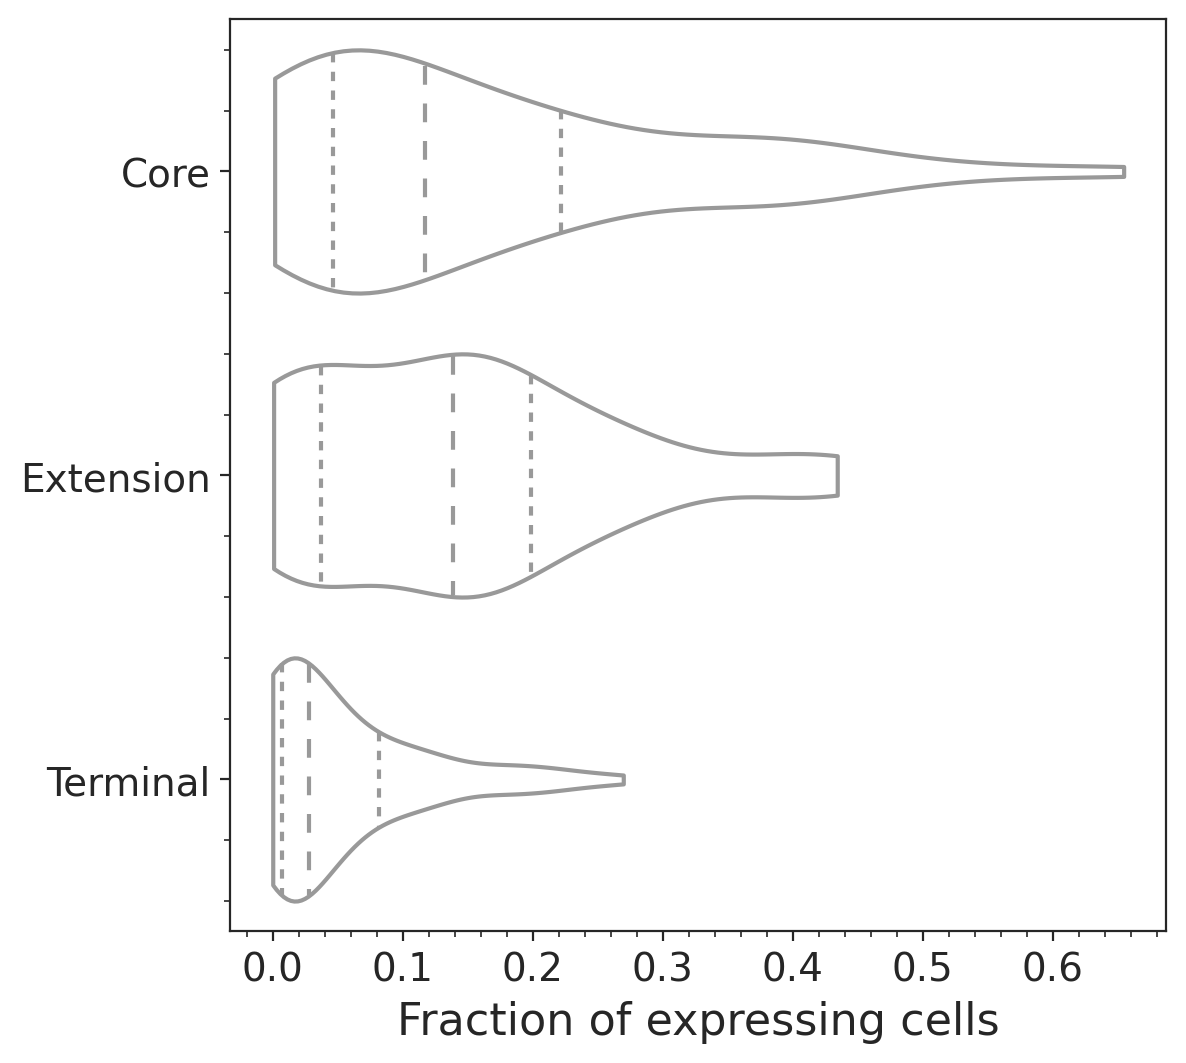

In [21]:
coreinfo_pd = coreinfo_pd.merge(tabula.var.reset_index(), how='left')

with plt.rc_context({'figure.figsize': (6, 6)}):
    ax = sns.violinplot(data = coreinfo_pd, x = 'fraction_cells', palette=['#FFFFFF', '#FFFFFF', '#FFFFFF'], ##C6BFBD
                          y = 'Groups', cut = 0, scale = 'width', inner = 'quartile')
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)
    ax.set_xlabel('Fraction of expressing cells', fontsize = 16)
    ax.xaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
    
    fig1 = ax.get_figure()
    fig.show()
    # fig1.savefig(''.join([plotDir, 'Genes_in_allcells10X_core.png']), bbox_inches = 'tight')

# plt.close()

### Optional: Fig 1g

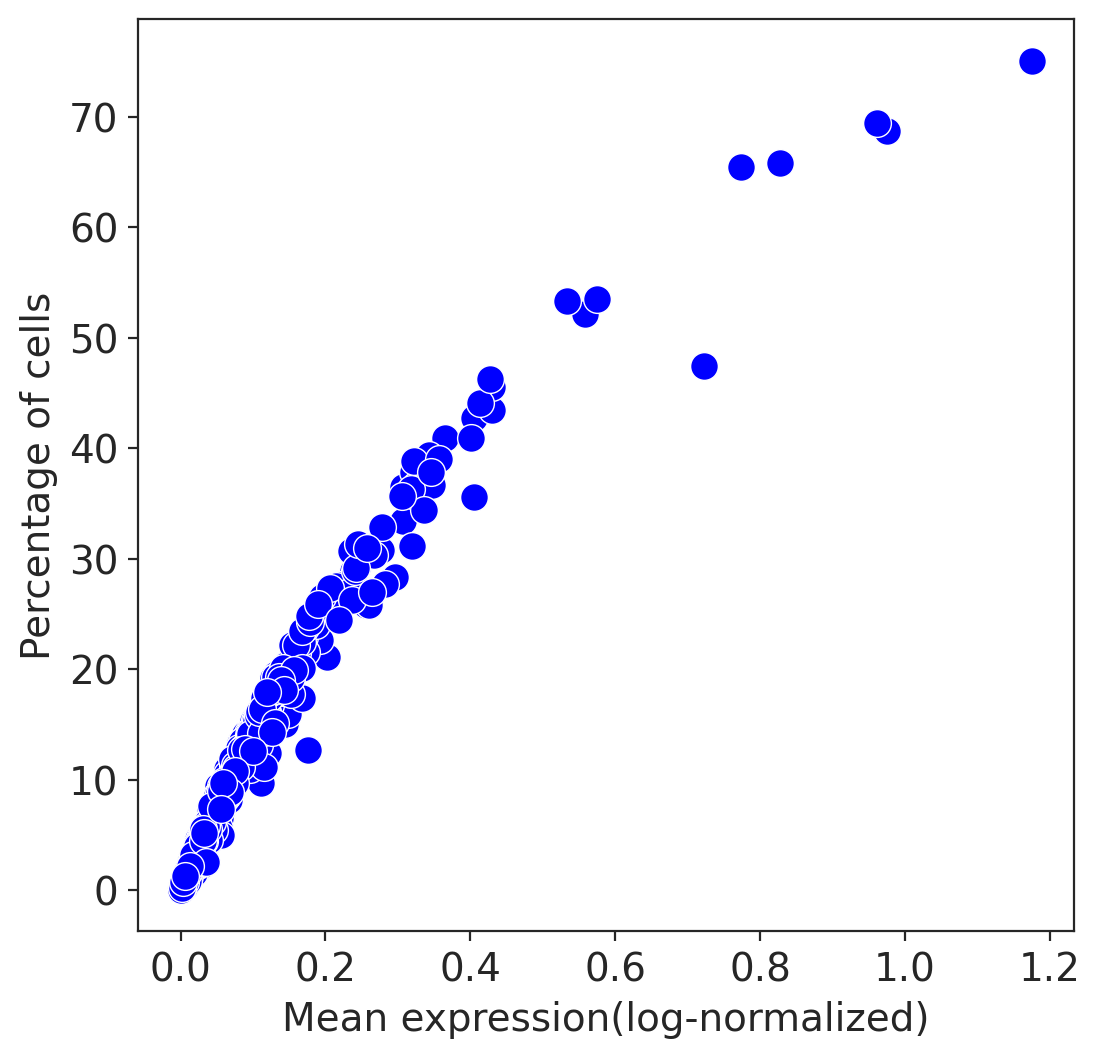

In [22]:
tabula.var['perc_cells'] = tabula.var['fraction_cells']*100
with plt.rc_context({'figure.figsize': (6, 6)}):
    ax = sns.scatterplot(data = tabula.var[tabula.var['isglyco']], x = "mean_expression",
                      y = "perc_cells", s=100, color='blue', linewidth=0.5)
    ax.set_xlabel('Mean expression(log-normalized)')
    ax.set_ylabel('Percentage of cells')

plt.show()
# g.savefig(''.join([plotDir, 'jointplot_glyco10X_perc_expr.png']))

# plt.close()

### Fig 1d(smaller)

In [23]:
# with plt.rc_context({'figure.figsize': (6, 6)}):
#     ax = sns.histplot(data = tabula.var, x = 'n_cells', hue_order = ["Glycogene", "Not Glycogene"], #palette=['#FFFFFF','#C6BFBD'], 
#                       stat = 'proportion', cumulative = False, alpha = 0.7, hue = 'isGlycogene',
#                       common_norm = False, multiple = 'dodge', element = 'bars', log_scale = False, bins = 20)
#     ax.set_xlim((200000, ax.get_xlim()[1]))
#     ax.set_ylim((0, 0.015))
#     ax2 = ax.twinx()
#     ax2.set_ylim(ax.get_ylim())
    
#     glycotickvals = np.arange(tabula.var['isglyco'].value_counts()[1], step=1)
#     glycoticks = glycotickvals/tabula.var['isglyco'].value_counts()[1]
#     glycotickvals = glycotickvals[glycoticks<=ax.get_yticks().max()]
#     glycoticks = glycoticks[glycoticks<=ax.get_yticks().max()]
    
#     tickvals = np.arange(tabula.var['isglyco'].value_counts()[0], step=50)
#     ticks = tickvals/tabula.var['isglyco'].value_counts()[0]
#     tickvals = tickvals[ticks<=ax.get_yticks().max()]
#     ticks = ticks[ticks<=ax.get_yticks().max()]
    
#     ax.set_yticks(glycoticks.tolist())
#     ax.set_yticklabels(glycotickvals.tolist())
    
#     ax2.set_yticks(ticks.tolist())
#     ax2.set_yticklabels(tickvals.astype(int).tolist())
#     ax.get_legend().remove()
    
#     samp1 = tabula.var.loc[-tabula.var['isglyco'], 'n_cells']
#     samp2 = tabula.var.loc[tabula.var['isglyco'], 'n_cells']
    
#     plt.axvline(np.quantile(samp2, 0.5), color='#1f77b4', linestyle = '--')
#     plt.axvline(np.quantile(samp1, 0.5), color='#ff7f0e', linestyle = '--')
#     ax.legend(title = '', labels = ["Other PC genes", "Glycogenes"], handlelength = 2)
    
#     wilc, p1 = stats.ranksums(samp1, samp2)
#     Mediandiff = samp1.median() - samp2.median()
#     annotator = Annotator(ax, [("Glycogene", "Not Glycogene")], data=tabula.var, x='isGlycogene', y='n_cells', order=["Glycogene", "Not Glycogene"])
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', text_offset = 0)
#     if Mediandiff>0:
#         annotator.configure(color='g')
#     else:
#         annotator.configure(color = 'r')
#     annotator.apply_and_annotate()
    
#     stars = ax.texts[0].get_text()
#     ax.texts[0].set_size(0)
#     ax.text(np.mean([np.quantile(samp2, 0.5), np.quantile(samp1, 0.5)]),0.48, stars, horizontalalignment = 'center')#Change y from 0.48 as appropriate height from figure top
#     ax.lines[-1].set_xdata((np.quantile(samp2, 0.5), np.quantile(samp2, 0.5), np.quantile(samp1, 0.5), np.quantile(samp1, 0.5)))
#     ax.lines[-1].set_linewidth(0)
    
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#     ax.set_ylabel('Number of glycogenes')
#     ax2.set_ylabel('Number of other PC genes')
#     ax.set_xlabel('Number of cells')

#     plt.show()
#     # plt.savefig(''.join([plotDir, 'Genes_in_allcells10X_cdf.png']), bbox_inches='tight')
    
# # plt.close()